将每个分组设计为一个元组。

元组首位元素为所属队伍。

次位元素为该分组的成员集合，是一个二元集合，保证了无序性，因为分组无需有序，任何顺序的二元组合都可以对应该映射情况。

In [1]:
import heapq
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.stats import norm
from collections import defaultdict, deque

自建组合类，保证可哈希，保证为无序对，设计原理理论：

1. 有first和second两个元素

2. 相应调用时，是有序的，保持初始添加进入的顺序

3. 进行比较和哈希操作时，不考虑顺序，只考虑元素

In [2]:
class Group:
    def __init__(self, first, second) -> None:
        self.first = first
        self.second = second
    def __repr__(self) -> str:
        return f"<{self.first}, {self.second}>"
    def __eq__(self, other) -> bool:
        return (self.first == other.first and self.second == other.second
                or self.first == other.second and self.second == other.first)
    def __lt__(self, other) -> bool:
        if self.first < other.first:
            return True
        elif self.first == other.first:
            return self.second < other.second
        return False
    def __gt__(self, other) -> bool:
        if self.first > other.first:
            return True
        elif self.first == other.first:
            return self.second > other.second
        return False
    def __hash__(self) -> int:
        if self.first < self.second:
            return hash((self.second, self.first))
        return hash((self.first, self.second))

In [3]:
g1, g2 = Group(1, 2), Group(2, 1)
if g1 == g2:
    print(f"g1: {g1} == g2: {g2}")
d = defaultdict(int)
d[g1] += 1
d[g2] += 1
d

g1: <1, 2> == g2: <2, 1>


defaultdict(int, {<1, 2>: 2})

In [4]:
def get_group(seq1, seq2):
    set_list = []
    for first, second in zip(seq1, seq2):
        if first != second:
            temp = Group(int(first[-1]), int(second[-1]))
            set_list.append((first[0], temp))
    return set_list

In [5]:
df = pd.read_csv(r'../table_1.csv', header=None)
df['A'] = get_group(df[2], df[3])
df['B'] = get_group(df[4], df[5])
df['Score_A'] = df[6].apply(lambda x: int(x.split(':')[0]))
df['Score_B'] = df[6].apply(lambda x: int(x.split(':')[1]))
df = df[['A', 'B', 'Score_A', 'Score_B']]
df['Difference'] = df['Score_A'] - df['Score_B']
df['Winner'] = df['Difference'].apply(lambda x: 'A' if x > 0 else 'B')
df.to_csv(r'../table_1_pre.csv', index=False)
df

,A,B,Score_A,Score_B,Difference,Winner
0,"(A, <1, 2>)","(B, <1, 2>)",23,21,2,A
1,"(A, <1, 2>)","(B, <1, 2>)",21,18,3,A
2,"(A, <1, 2>)","(B, <1, 2>)",21,19,2,A
3,"(A, <2, 3>)","(B, <2, 3>)",21,15,6,A
4,"(A, <2, 3>)","(B, <2, 3>)",21,12,9,A
5,"(A, <1, 3>)","(B, <1, 2>)",20,22,-2,B
6,"(A, <1, 3>)","(B, <1, 2>)",21,19,2,A
7,"(A, <1, 3>)","(B, <1, 2>)",22,20,2,A
8,"(A, <2, 4>)","(B, <2, 4>)",21,15,6,A
9,"(A, <2, 4>)","(B, <2, 4>)",13,21,-8,B


In [6]:
index, temp_diff_list, temp_tag_list = -1, list(), list()
game_list, score_list, diff_list, tag_list, game_history_score = list(), list(), list(), list(), tuple()
for line in df.iterrows():
    line = line[-1].copy()
    tp = (line['A'], line['B'])
    if tp not in game_list and len(game_list) > 0:
        diff_list.append(temp_diff_list)
        tag_list.append(temp_tag_list)
    if tp not in game_list:
        game_list.append(tp)
        index += 1
        game_history_score = (0, 0)
        temp_diff_list = []
        temp_tag_list = []
    if line['Difference'] > 0:
        game_history_score = (game_history_score[0] + 1, game_history_score[1])
    else:
        game_history_score = (game_history_score[0], game_history_score[1] + 1)
    temp_diff_list.append(line['Difference'])
    if line['Score_A'] >= 20 and line['Score_B'] >= 20:
        temp_tag_list.append(1)
    else:
        temp_tag_list.append(0)
    if len(score_list) == index:
        score_list.append(game_history_score)
    else:
        score_list[index] = game_history_score
diff_list.append(temp_diff_list)
tag_list.append(temp_tag_list)

df_games = pd.DataFrame()
df_games['games'] = game_list
df_games['score'] = score_list
df_games['A'] = df_games['games'].apply(lambda x: x[0])
df_games['B'] = df_games['games'].apply(lambda x: x[1])
df_games['A_Score'] = df_games['score'].apply(lambda x: x[0])
df_games['B_Score'] = df_games['score'].apply(lambda x: x[1])
df_games['Diff'] = diff_list
df_games['Tag'] = tag_list
df_games.drop(['games', 'score'], axis=1, inplace=True)
df_games.to_csv(r'../games.csv', index=False)
df_games

,A,B,A_Score,B_Score,Diff,Tag
0,"(A, <1, 2>)","(B, <1, 2>)",3,0,"[2, 3, 2]","[1, 0, 0]"
1,"(A, <2, 3>)","(B, <2, 3>)",2,0,"[6, 9]","[0, 0]"
2,"(A, <1, 3>)","(B, <1, 2>)",2,1,"[-2, 2, 2]","[1, 0, 1]"
3,"(A, <2, 4>)","(B, <2, 4>)",1,1,"[6, -8]","[0, 0]"
4,"(A, <1, 4>)","(B, <2, 4>)",2,1,"[-3, 4, 2]","[0, 0, 0]"
5,"(A, <2, 5>)","(B, <3, 5>)",2,0,"[9, 5]","[0, 0]"
6,"(A, <1, 5>)","(B, <1, 5>)",2,1,"[-3, 7, 5]","[0, 0, 0]"
7,"(A, <3, 4>)","(B, <4, 5>)",1,0,[7],[0]
8,"(A, <4, 5>)","(B, <3, 5>)",1,1,"[10, -7]","[0, 0]"
9,"(A, <3, 4>)","(B, <3, 4>)",1,1,"[-2, 2]","[0, 1]"


观察胜负情况

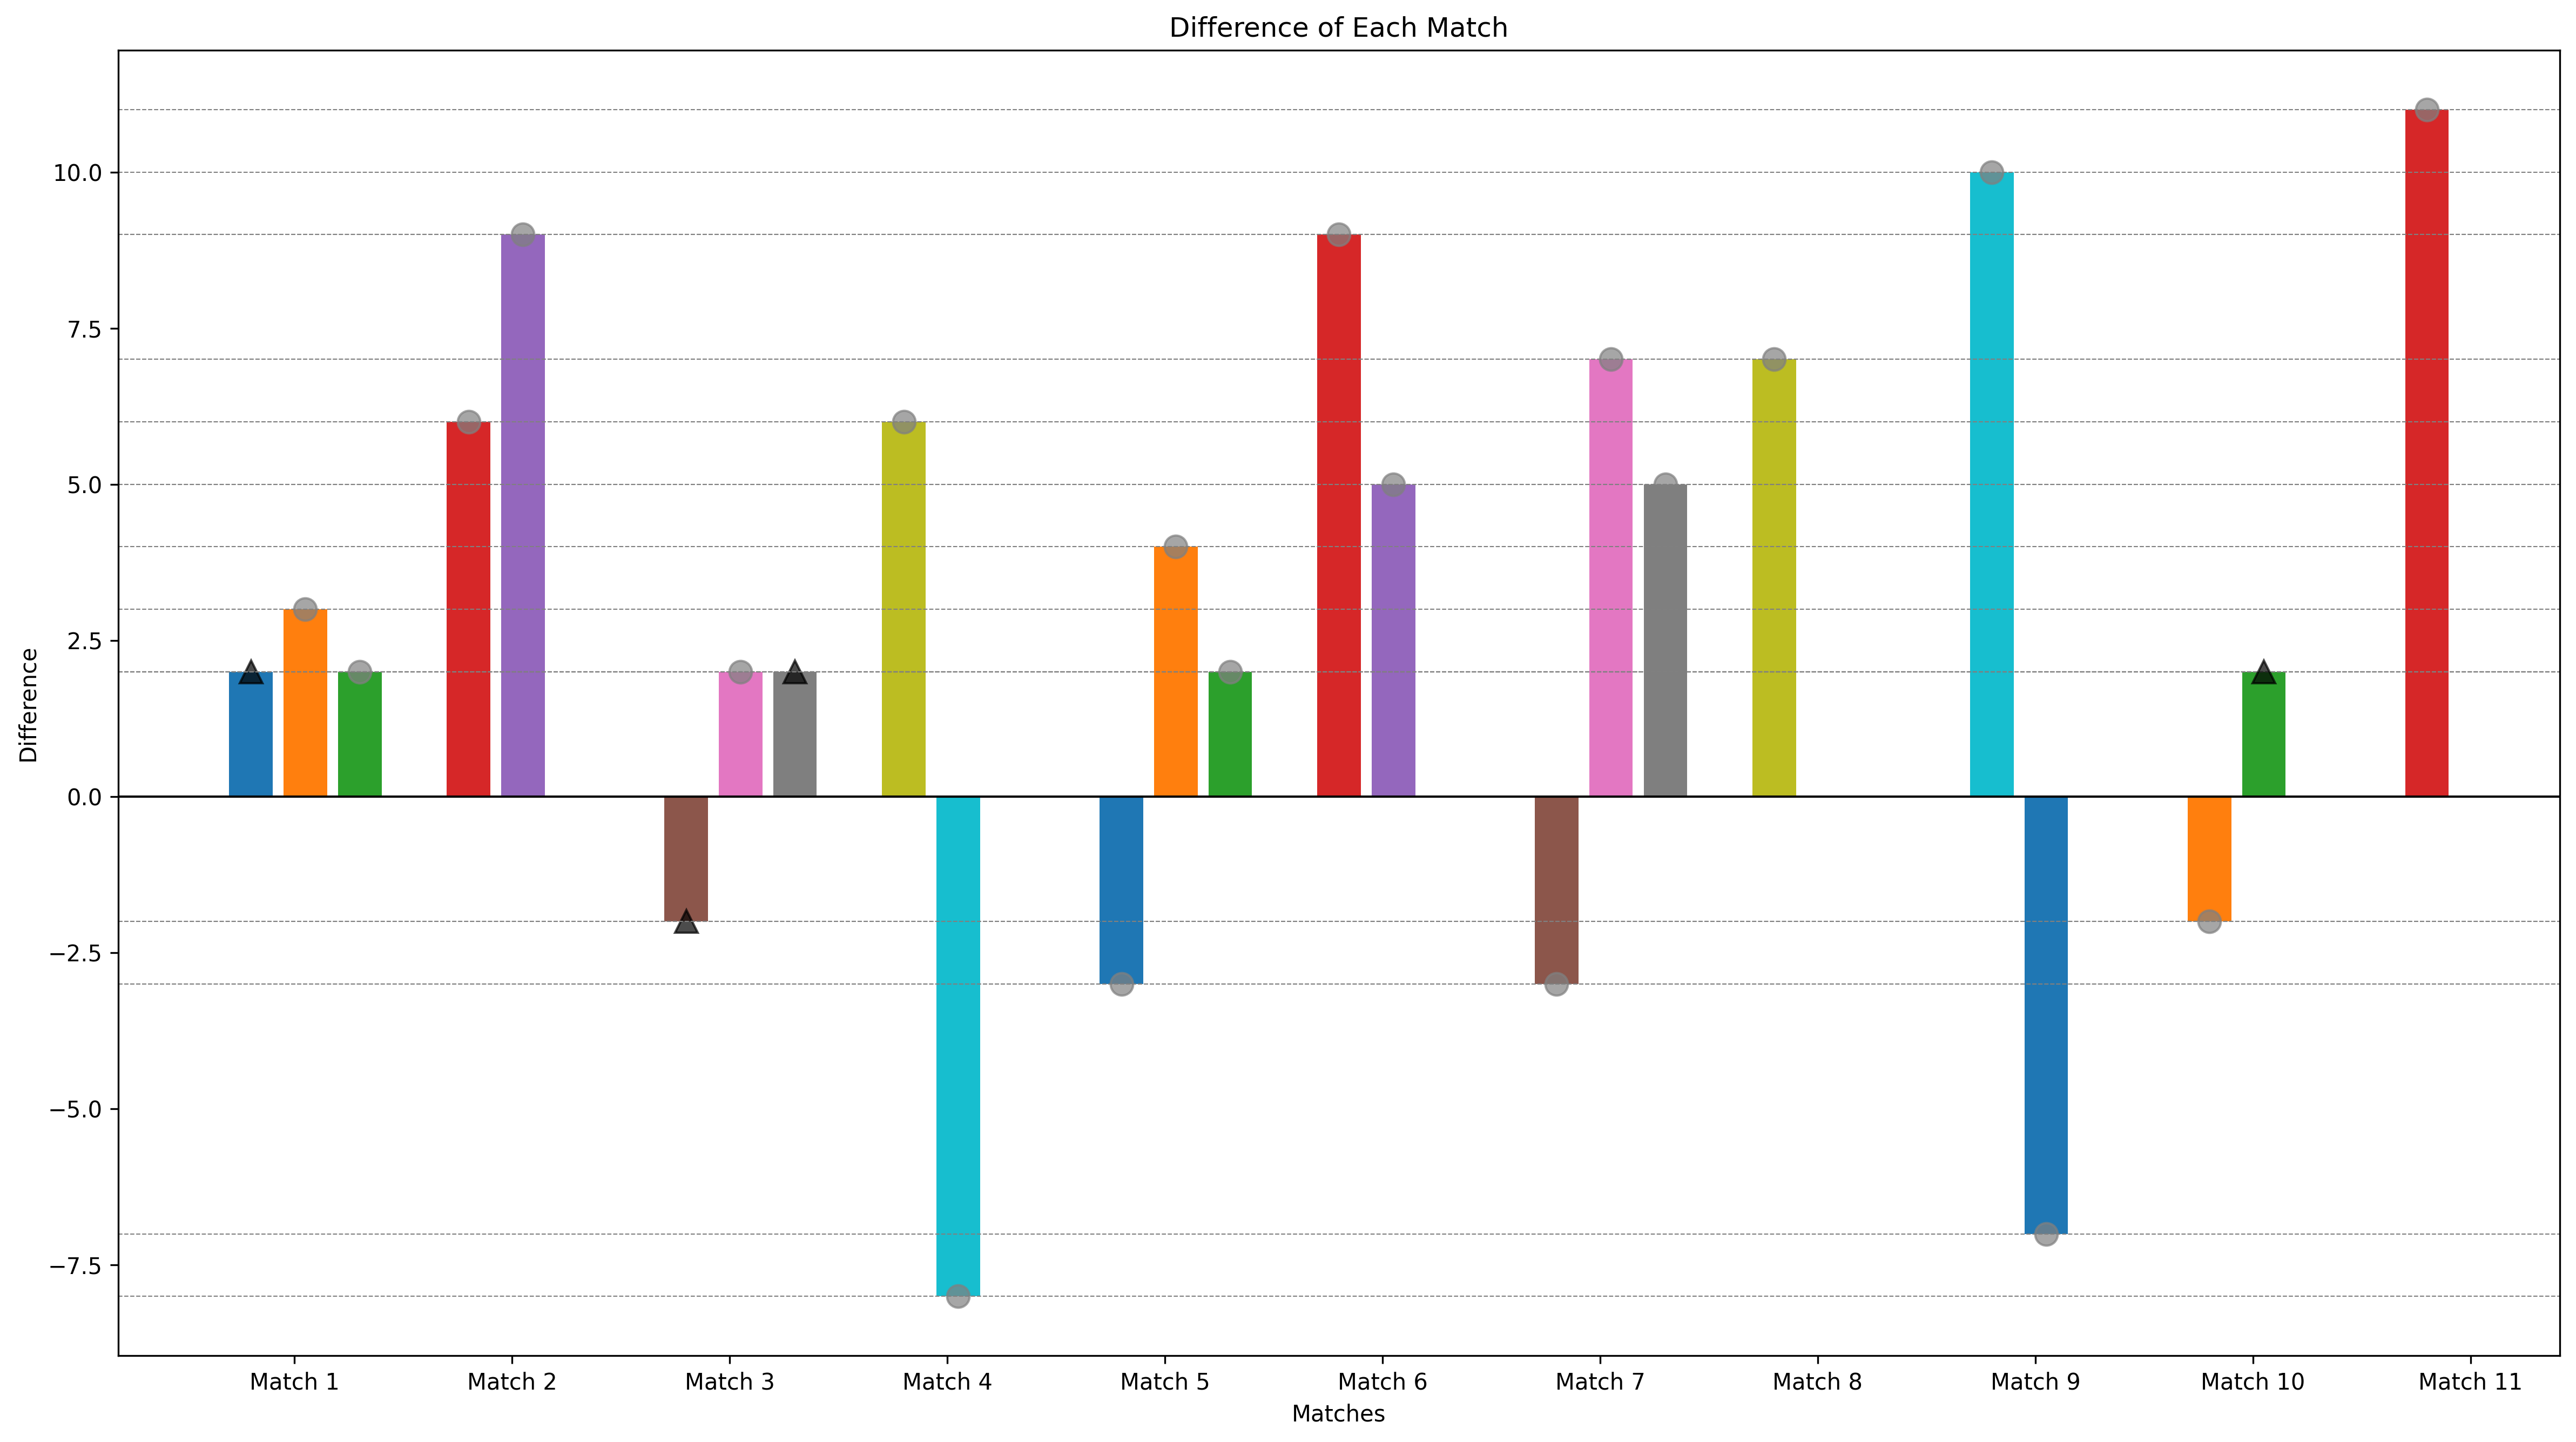

In [7]:
plt.figure(figsize=(16, 9), dpi=300)
ax = plt.gca()

bar_width = 0.2
bar_spacing = 0.05
for i, (diff_list, tag_list) in enumerate(zip(df_games['Diff'], df_games['Tag'])):
    for j, (diff, tag) in enumerate(zip(diff_list, tag_list)):
        x_position = i + j * (bar_width + bar_spacing) - 0.2
        if tag == 1:
            ax.bar(x_position, diff, width=bar_width, label=f'Match {i}', align='center')
        else:
            ax.bar(x_position, diff, width=bar_width, label=f'Match {i}', align='center')
        ax.axhline(y=diff, color='gray', linestyle='--', linewidth=0.5)
        ax.plot(x_position, diff, marker='^' if tag == 1 else 'o', markersize=10, color='black' if tag == 1 else 'grey', alpha=0.7)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)

ax.set_xticks(ticks=range(len(df_games)))
ax.set_xticklabels([f'Match {i + 1}' for i in range(len(df_games))])
ax.set_xlabel('Matches')
ax.set_ylabel('Difference')
ax.set_title('Difference of Each Match')

plt.tight_layout()
plt.show()

绘制二部图，观察节点分布

In [8]:
G = nx.MultiDiGraph()

plt.figure(figsize=(10, 10), dpi=300)

for _, row in df_games.iterrows():
    for diff, tag in zip(row['Diff'], row['Tag']):
        diff = diff + tag if diff < 0 else diff - tag
        winner = row['A'] if diff > 0 else row['B']
        loser = row['B'] if diff > 0 else row['A']
        G.add_edge(winner, loser, weight=diff)

A_team = {elem for elem in G.nodes() if elem[0] == 'A'}
B_team = set(G) - A_team

# pos = nx.bipartite_layout(G, A_team)

# nx.draw_networkx_nodes(G, pos, nodelist=A_team, node_color='teal', node_size=1000, label='A_team')
# nx.draw_networkx_nodes(G, pos, nodelist=B_team, node_color='coral', node_size=1000, label='B_team')

# weights = [d['weight'] for _, _, d in G.edges(data=True)]
# max_weight = max(weights)
# min_weight = min(weights)
# cmap = plt.cm.bwr  
# norm = mcolors.TwoSlopeNorm(vmin=min_weight, vcenter=0, vmax=max_weight)
# for u, v, d_dict in G.edges(data=True):
#     if G.number_of_edges(u, v) == 1:
#         weight = d_dict['weight']
#         edge_color = cmap(norm(weight))  
#         nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=edge_color,
#                                connectionstyle=f"arc3,rad={0.1 if u[0] == 'A' else -0.1}")
#     else:
#         shift = 0.03 if u[0] == 'A' else -0.03
#         for i, (edge, data) in enumerate(G[u][v].items()):
#             angle = 0.1 * i * (-1) ** i
#             weight = data['weight']
#             edge_color = cmap(norm(weight)) 
#             nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=edge_color,
#                                    connectionstyle=f"arc3,rad={angle + shift * i}")

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, orientation='horizontal', fraction=0.05, pad=0.05)
# cbar.set_label('Edge Weight')

# nx.draw_networkx_labels(G, pos, font_size=7, font_weight='bold')

# plt.legend(loc='lower center', ncol=2, columnspacing=4.0, markerscale=0.4, handleheight=1, scatterpoints=1)
# plt.savefig('../imgs/graph.png', dpi=300)
# plt.title('Bipartite Graph of Team A and B')
# plt.show()

<Figure size 3000x3000 with 0 Axes>

In [9]:
df_games

,A,B,A_Score,B_Score,Diff,Tag
0,"(A, <1, 2>)","(B, <1, 2>)",3,0,"[2, 3, 2]","[1, 0, 0]"
1,"(A, <2, 3>)","(B, <2, 3>)",2,0,"[6, 9]","[0, 0]"
2,"(A, <1, 3>)","(B, <1, 2>)",2,1,"[-2, 2, 2]","[1, 0, 1]"
3,"(A, <2, 4>)","(B, <2, 4>)",1,1,"[6, -8]","[0, 0]"
4,"(A, <1, 4>)","(B, <2, 4>)",2,1,"[-3, 4, 2]","[0, 0, 0]"
5,"(A, <2, 5>)","(B, <3, 5>)",2,0,"[9, 5]","[0, 0]"
6,"(A, <1, 5>)","(B, <1, 5>)",2,1,"[-3, 7, 5]","[0, 0, 0]"
7,"(A, <3, 4>)","(B, <4, 5>)",1,0,[7],[0]
8,"(A, <4, 5>)","(B, <3, 5>)",1,1,"[10, -7]","[0, 0]"
9,"(A, <3, 4>)","(B, <3, 4>)",1,1,"[-2, 2]","[0, 1]"


In [10]:
a_team, b_team = set(), set()
for i in range(5):
    for j in range(i + 1, 5):
        a_team.add(('A', Group(i + 1, j + 1)))
        b_team.add(('B', Group(i + 1, j + 1)))
print(a_team, b_team, sep='\n')

{('A', <1, 3>), ('A', <2, 4>), ('A', <2, 5>), ('A', <4, 5>), ('A', <1, 2>), ('A', <1, 4>), ('A', <1, 5>), ('A', <2, 3>), ('A', <3, 4>), ('A', <3, 5>)}
{('B', <2, 3>), ('B', <1, 5>), ('B', <3, 4>), ('B', <3, 5>), ('B', <1, 3>), ('B', <2, 4>), ('B', <2, 5>), ('B', <1, 2>), ('B', <4, 5>), ('B', <1, 4>)}


In [11]:
possible_pairs = []
for a in a_team:
    for b in b_team:
        possible_pairs.append((a,b))
len(a_team), len(b_team), len(possible_pairs)

(10, 10, 100)

基于已有样本构建先验概率。

胜率，乘以权重（以差值之和的平均值为权重，表示胜利的权重），得出logits，随后利用sigmoid函数，将之映射到(0,1)的区间内，作为先验概率。

In [12]:
def get_prob(weight, row):
    score = (row['A_Score'], row['B_Score'])
    if weight >= 0:
        if score[0] > score[1]:
            return float(score[0] / sum(score)) * weight
        elif score[0] == score[1]:
            return float(score[0] / sum(score)) * weight
        else:
            return 0
    elif weight < 0:
        if score[0] < score[1]:
            return float(score[0] / sum(score)) * weight
        elif score[0] == score[1]:
            return float(score[0] / sum(score)) * weight
        else:
            return 0    

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [13]:
g = nx.DiGraph()
logits, weights, mean_diff = [], [], []
for _, row in df_games.iterrows():
    sum_diff = 0
    for diff, tag in zip(row['Diff'], row['Tag']):
        diff = diff + tag if diff < 0 else diff - tag
        sum_diff += diff
    weights.append(sum_diff)
    logits.append(get_prob(sum_diff / len(row['Diff']), row))
    mean_diff.append(sum_diff / len(row['Diff']))

probs = [sigmoid(logit) for logit in logits]

for (_, row), weight, prob, mean_diff in zip(df_games.iterrows(), weights, probs, mean_diff):
    g.add_edge(
        row['A'], row['B'], 
        weight=weight, 
        score=(row['A_Score'], row['B_Score']),
        diff=row['Diff'],
        tag=row['Tag'],
        prob=prob,
        mean_diff=mean_diff
    )

for edge in g.edges(data=True):
    print(edge)

(('A', <1, 2>), ('B', <1, 2>), {'weight': 6, 'score': (3, 0), 'diff': [2, 3, 2], 'tag': [1, 0, 0], 'prob': 0.8807970779778823, 'mean_diff': 2.0})
(('A', <2, 3>), ('B', <2, 3>), {'weight': 15, 'score': (2, 0), 'diff': [6, 9], 'tag': [0, 0], 'prob': 0.9994472213630764, 'mean_diff': 7.5})
(('A', <1, 3>), ('B', <1, 2>), {'weight': 2, 'score': (2, 1), 'diff': [-2, 2, 2], 'tag': [1, 0, 1], 'prob': 0.6093175418435606, 'mean_diff': 0.6666666666666666})
(('A', <1, 3>), ('B', <3, 5>), {'weight': 11, 'score': (1, 0), 'diff': [11], 'tag': [0], 'prob': 0.999983298578152, 'mean_diff': 11.0})
(('A', <2, 4>), ('B', <2, 4>), {'weight': -2, 'score': (1, 1), 'diff': [6, -8], 'tag': [0, 0], 'prob': 0.3775406687981454, 'mean_diff': -1.0})
(('A', <1, 4>), ('B', <2, 4>), {'weight': 3, 'score': (2, 1), 'diff': [-3, 4, 2], 'tag': [0, 0, 0], 'prob': 0.6607563687658172, 'mean_diff': 1.0})
(('A', <2, 5>), ('B', <3, 5>), {'weight': 14, 'score': (2, 0), 'diff': [9, 5], 'tag': [0, 0], 'prob': 0.9990889488055994, 'me

In [14]:
g_prob = nx.DiGraph()

for (_, row), prob in zip(df_games.iterrows(), probs):
    g_prob.add_edge(row['A'], row['B'], prob=prob)

# 添加所有情况的无序对顶点
for a in a_team:
    for b in b_team:
        if (a, b) not in g_prob:
            g_prob.add_edge(a, b, prob=0)
        
# 从基础顶点连接无序对顶点
for u in range(5):
    for v in range(5):
        if u != v:
            g_prob.add_edge(('A', u + 1), ('A', Group(u + 1, v + 1)), prob=0)
            g_prob.add_edge(('B', u + 1), ('B', Group(u + 1, v + 1)), prob=0)
            
for edge in g_prob.edges(data=True):
    print(edge)

(('A', <1, 2>), ('B', <1, 2>), {'prob': 0})
(('A', <1, 2>), ('B', <2, 3>), {'prob': 0})
(('A', <1, 2>), ('B', <1, 5>), {'prob': 0})
(('A', <1, 2>), ('B', <3, 4>), {'prob': 0})
(('A', <1, 2>), ('B', <3, 5>), {'prob': 0})
(('A', <1, 2>), ('B', <1, 3>), {'prob': 0})
(('A', <1, 2>), ('B', <2, 4>), {'prob': 0})
(('A', <1, 2>), ('B', <2, 5>), {'prob': 0})
(('A', <1, 2>), ('B', <4, 5>), {'prob': 0})
(('A', <1, 2>), ('B', <1, 4>), {'prob': 0})
(('A', <2, 3>), ('B', <2, 3>), {'prob': 0})
(('A', <2, 3>), ('B', <1, 5>), {'prob': 0})
(('A', <2, 3>), ('B', <3, 4>), {'prob': 0})
(('A', <2, 3>), ('B', <3, 5>), {'prob': 0})
(('A', <2, 3>), ('B', <1, 3>), {'prob': 0})
(('A', <2, 3>), ('B', <2, 4>), {'prob': 0})
(('A', <2, 3>), ('B', <2, 5>), {'prob': 0})
(('A', <2, 3>), ('B', <1, 2>), {'prob': 0})
(('A', <2, 3>), ('B', <4, 5>), {'prob': 0})
(('A', <2, 3>), ('B', <1, 4>), {'prob': 0})
(('A', <1, 3>), ('B', <1, 2>), {'prob': 0})
(('A', <1, 3>), ('B', <3, 5>), {'prob': 0})
(('A', <1, 3>), ('B', <2, 3>), {

要在正态分布的 \([μ - 3σ, μ + 3σ]\) 区间内，沿x轴和正态分布曲线所围成的平面内部随机取点并得出其x值，可以遵循以下步骤：

1. **确定正态分布参数**：首先，您需要知道正态分布的均值（μ）和标准差（σ）。在这个例子中，虽然具体的μ和σ没有给出，但我们知道我们关注的是从μ减去3倍标准差到加上3倍标准差的范围。

2. **生成随机概率值**：在正态分布的给定范围内随机取点，实质上是生成一个该区间内的随机概率值。因为正态分布是连续分布，我们可以通过生成一个[0,1]之间的均匀随机数，然后映射到正态分布的累积分布函数(CDF)对应的概率值。

3. **反变换采样**：利用反累积分布函数（inverse CDF，也称作百分位数函数），将上一步得到的概率值转化为x轴上的值。对于正态分布，这通常涉及到使用标准正态分布的累积分布函数的逆函数（即Q函数或erfinv函数），然后根据需要调整到具体的均值和标准差。

在Python中，可以使用`scipy.stats.norm`模块来实现这一过程：

```python
import numpy as np
from scipy.stats import norm

# 假设的正态分布参数
mu = 0  # 均值
sigma = 1  # 标准差

# 生成一个[0, 1]之间的随机概率值
random_probability = np.random.rand()

# 使用累积分布函数的逆函数（percent point function，即反变换）找到对应的x值
# 注意：ppf函数接受的是累积概率，所以我们直接使用random_probability
random_x_in_interval = norm.ppf(random_probability, loc=mu, scale=sigma)

# 确保结果在[μ-3σ, μ+3σ]区间内，实际上由于正态分布的性质，上面的步骤已经隐含了这一点
# 但为了严谨，可以添加条件检查（在本例中通常不需要）
lower_bound = mu - 3*sigma
upper_bound = mu + 3*sigma

if lower_bound <= random_x_in_interval <= upper_bound:
    print("随机选取的x值在指定区间内:", random_x_in_interval)
else:
    # 实际上这个else分支几乎不会执行，因为ppf已经考虑了范围
    print("生成的点意外地不在[μ-3σ, μ+3σ]区间内")
```

这段代码首先生成一个随机概率值，然后使用`norm.ppf`函数将其转化为正态分布中的一个x值。由于我们直接在正态分布上操作，生成的x值自然会在整个分布范围内，包括在\[μ-3σ, μ+3σ\]的指定区间内。

In [39]:
import numpy as np
from scipy.stats import norm

# 假设的正态分布参数


# 生成一个[0, 1]之间的随机概率值
random_probability = np.random.rand()
np.random.randn()
print(f"随机选取的概率值:", random_probability)

# 使用累积分布函数的逆函数（percent point function，即反变换）找到对应的x值
# 注意：ppf函数接受的是累积概率，所以我们直接使用random_probability
random_x_in_interval = norm.ppf(random_probability, loc=mu, scale=sigma)

# 确保结果在[μ-3σ, μ+3σ]区间内，实际上由于正态分布的性质，上面的步骤已经隐含了这一点
# 但为了严谨，可以添加条件检查（在本例中通常不需要）
lower_bound = mu - 3*sigma
upper_bound = mu + 3*sigma

if lower_bound <= random_x_in_interval <= upper_bound:
    print(f"随机选取的x值在指定区间{[lower_bound, upper_bound]}内:", random_x_in_interval)
else:
    # 实际上这个else分支几乎不会执行，因为ppf已经考虑了范围
    print("生成的点意外地不在[μ-3σ, μ+3σ]区间内")

随机选取的概率值: 0.7941479019326484
随机选取的x值在指定区间[-3, 3]内: 0.8208983058709561


In [ ]:
def get_rand():
    mu = 0  # 均值
    sigma = 1  # 标准差
    random_probability = np.random.rand()
    random_x_in_interval = norm.ppf(random_probability, loc=mu, scale=sigma)
    

In [15]:
data_mat = {}
for a_combination in a_team:
    data_mat[a_combination] = {}
    for b_combination in b_team:
        data_mat[a_combination][b_combination] = sigmoid(0)

for entry in g.edges(data=True):
    team_a_combination = entry[0]
    team_b_combination = entry[1]
    win_probability = entry[2]['prob']
    data_mat[team_a_combination][team_b_combination] = win_probability

adj_mat = pd.DataFrame(
    index=sorted(list(a_team), key=lambda x: (x[1].first, x[1].second)), 
    columns=sorted(list(b_team), key=lambda x: (x[1].first, x[1].second))
)

for index, row in adj_mat.iterrows():
    temp = data_mat[index].values()
    for column in row.index:
        row[column] = data_mat[index][column]

adj_mat

,"(B, <1, 2>)","(B, <1, 3>)","(B, <1, 4>)","(B, <1, 5>)","(B, <2, 3>)","(B, <2, 4>)","(B, <2, 5>)","(B, <3, 4>)","(B, <3, 5>)","(B, <4, 5>)"
"(A, <1, 2>)",0.880797,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(A, <1, 3>)",0.609318,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.999983,0.5
"(A, <1, 4>)",0.5,0.5,0.5,0.5,0.5,0.660756,0.5,0.5,0.5,0.5
"(A, <1, 5>)",0.5,0.5,0.5,0.880797,0.5,0.5,0.5,0.5,0.5,0.5
"(A, <2, 3>)",0.5,0.5,0.5,0.5,0.999447,0.5,0.5,0.5,0.5,0.5
"(A, <2, 4>)",0.5,0.5,0.5,0.5,0.5,0.377541,0.5,0.5,0.5,0.5
"(A, <2, 5>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.999089,0.5
"(A, <3, 4>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.437823,0.5,0.999089
"(A, <3, 5>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(A, <4, 5>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.679179,0.5


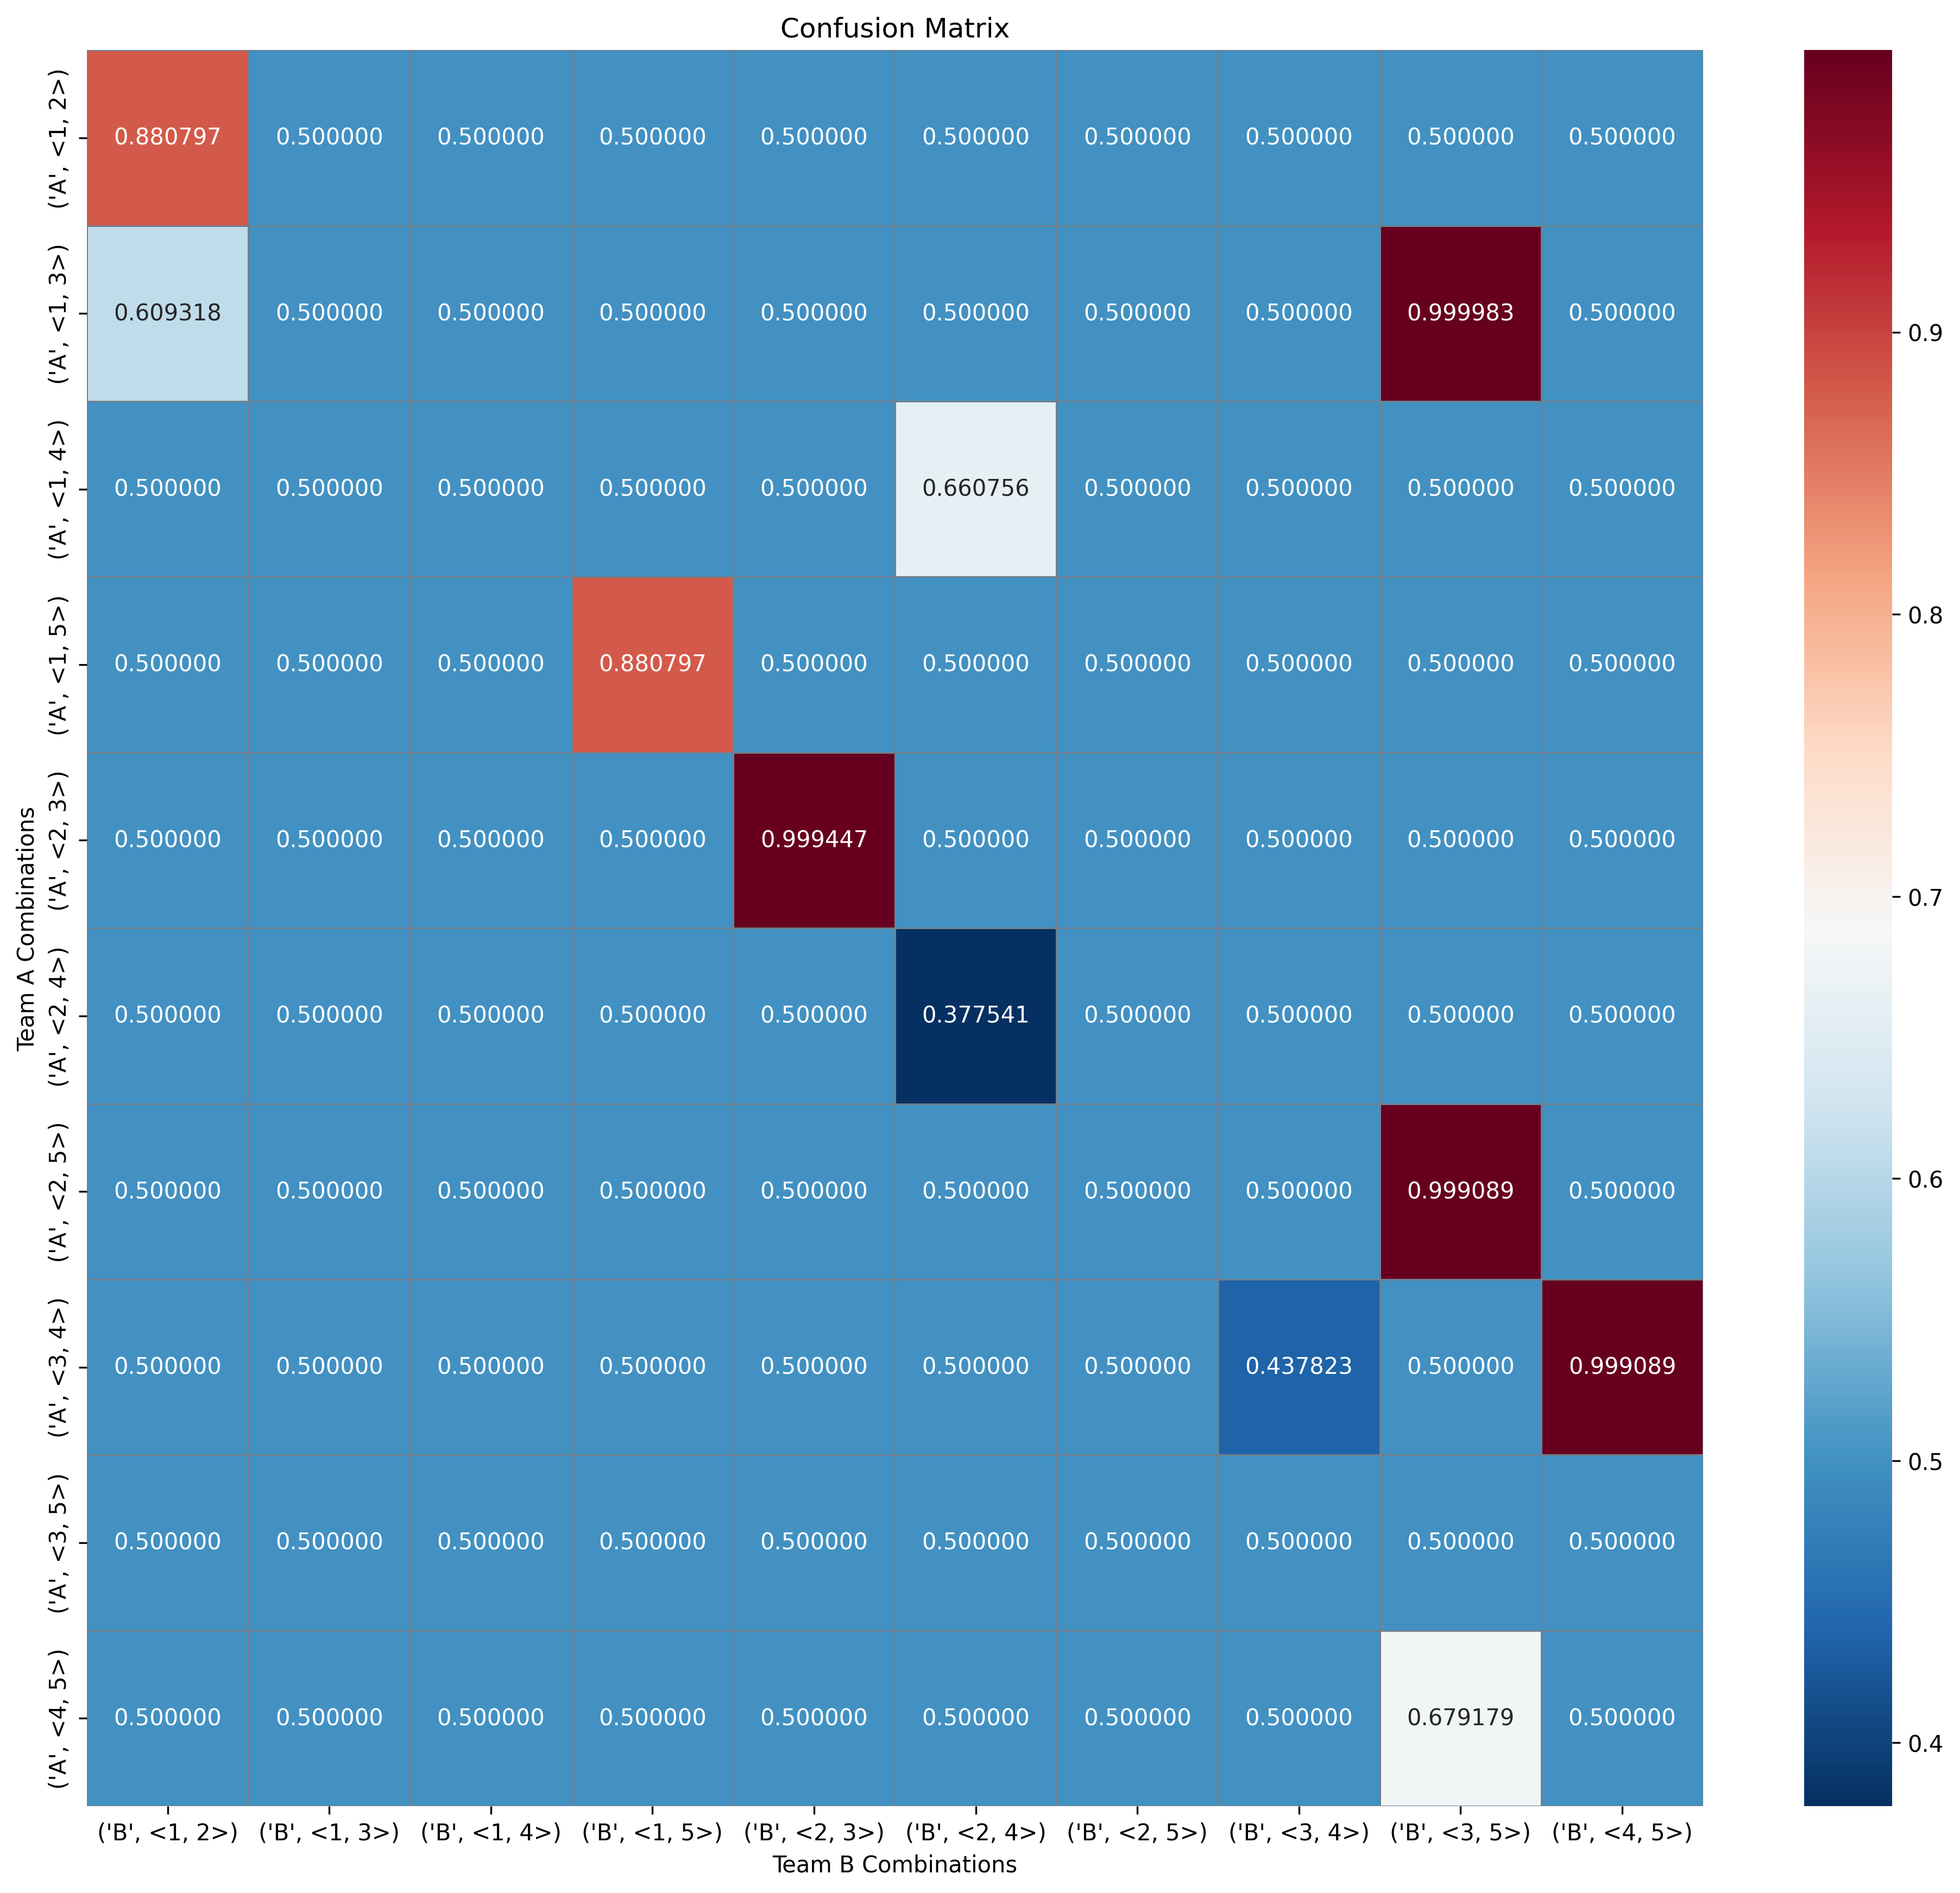

In [16]:
matrix_df = adj_mat.astype(float)

plt.figure(figsize=(16, 14), dpi=300)
sns.heatmap(matrix_df, cmap="RdBu_r", annot=True, fmt=".6f", linewidths=0.6, linecolor='slategray')
plt.title('Confusion Matrix')
plt.xlabel('Team B Combinations')
plt.ylabel('Team A Combinations')
plt.show()

# Problem 1

In [17]:
def mat2list(adj_mat):
    size = len(adj_mat)
    adj_list = defaultdict(list)
    for (_, col), row in adj_mat.iterrows():
        adj_list[col.first].append((col.second, [(k, v) for k, v in zip(row.index, row)]))
        adj_list[col.second].append((col.first, [(k, v) for k, v in zip(row.index, row)]))
    return adj_list

def combine(team, tp):
    return (team, Group(*tp))

class Simulator:
    def __init__(self, adj_mat):
        self.adj_list = mat2list(adj_mat)

class SimulatorA(Simulator):
    def __init__(self, adj_mat):
        super(SimulatorA, self).__init__(adj_mat)
        self.b_name2tok =  {b: i for i, b in enumerate(adj_mat.columns)}

class SimulatorB(Simulator):
    def __init__(self, adj_mat):
        super(SimulatorB, self).__init__(adj_mat)
        self.a_name2tok = {a: i for i, a in enumerate(adj_mat.columns)}

sim = SimulatorA(adj_mat=adj_mat)
for k, v in sim.adj_list.items():
    print(k, v)
print(sim.b_name2tok)

1 [(2, [(('B', <1, 2>), 0.8807970779778823), (('B', <1, 3>), 0.5), (('B', <1, 4>), 0.5), (('B', <1, 5>), 0.5), (('B', <2, 3>), 0.5), (('B', <2, 4>), 0.5), (('B', <2, 5>), 0.5), (('B', <3, 4>), 0.5), (('B', <3, 5>), 0.5), (('B', <4, 5>), 0.5)]), (3, [(('B', <1, 2>), 0.6093175418435606), (('B', <1, 3>), 0.5), (('B', <1, 4>), 0.5), (('B', <1, 5>), 0.5), (('B', <2, 3>), 0.5), (('B', <2, 4>), 0.5), (('B', <2, 5>), 0.5), (('B', <3, 4>), 0.5), (('B', <3, 5>), 0.999983298578152), (('B', <4, 5>), 0.5)]), (4, [(('B', <1, 2>), 0.5), (('B', <1, 3>), 0.5), (('B', <1, 4>), 0.5), (('B', <1, 5>), 0.5), (('B', <2, 3>), 0.5), (('B', <2, 4>), 0.6607563687658172), (('B', <2, 5>), 0.5), (('B', <3, 4>), 0.5), (('B', <3, 5>), 0.5), (('B', <4, 5>), 0.5)]), (5, [(('B', <1, 2>), 0.5), (('B', <1, 3>), 0.5), (('B', <1, 4>), 0.5), (('B', <1, 5>), 0.8807970779778823), (('B', <2, 3>), 0.5), (('B', <2, 4>), 0.5), (('B', <2, 5>), 0.5), (('B', <3, 4>), 0.5), (('B', <3, 5>), 0.5), (('B', <4, 5>), 0.5)])]
2 [(1, [(('B', 

In [18]:
B = [1, 2, 3, 4, 5]
B_row = [(B[i], B[i + 1]) if i < len(B) - 1 else (B[i], B[0]) for i in range(len(B))]
b_ids = [sim.b_name2tok[combine('B', i)] for i in B_row]
B_row, b_ids

([(1, 2), (2, 3), (3, 4), (4, 5), (5, 1)], [0, 4, 7, 9, 3])

In [19]:
a_seqs = []

def dfs(start, prev, b_idx, b_ids, b_visited, a_visited, a_seq, global_prob):
    a_visited.add(prev)
    a_seq.append(prev)
    b_id = b_ids[b_idx]
    next_vec = [(k, v[b_id][-1]) for k, v in sim.adj_list[prev]]
    b_visited[b_idx] = True
    for ptr, prob in next_vec:
        if ptr == start and len(a_seq) == len(b_ids):
            a_seqs.append((a_seq, global_prob * prob))
        if ptr not in a_visited:
            dfs(start=start, prev=ptr, b_idx=b_idx + 1, b_ids=b_ids, 
                b_visited=b_visited.copy(), a_visited=a_visited.copy(), 
                a_seq=a_seq.copy(),
                global_prob=(prob * global_prob).copy())


for idx in range(len(b_ids)):
    a_visited = set()
    b_visited = [False] * (len(b_ids))

    a_first_id = idx + 1
    dfs(start=a_first_id , prev=a_first_id, b_idx=0, b_ids=b_ids, 
        b_visited=b_visited, a_visited=a_visited,
        a_seq=[], global_prob=1)

In [30]:
first_five = sorted(a_seqs, key=lambda x: x[-1], reverse=True)[:10]
pd.DataFrame(first_five, columns=['Sequence', 'Probability'])

,Sequence,Probability
0,"[1, 2, 3, 4, 5]",0.169739
1,"[1, 3, 2, 4, 5]",0.134097
2,"[1, 2, 3, 5, 4]",0.110039
3,"[5, 3, 2, 4, 1]",0.110039
4,"[1, 2, 5, 3, 4]",0.109999
5,"[1, 2, 5, 4, 3]",0.109999
6,"[2, 1, 5, 3, 4]",0.109999
7,"[2, 1, 5, 4, 3]",0.109999
8,"[5, 2, 3, 4, 1]",0.096355
9,"[1, 2, 4, 3, 5]",0.084916


# Problem 2

In [21]:
adj_mat_b = 1 - adj_mat.transpose()
adj_mat_b

,"(A, <1, 2>)","(A, <1, 3>)","(A, <1, 4>)","(A, <1, 5>)","(A, <2, 3>)","(A, <2, 4>)","(A, <2, 5>)","(A, <3, 4>)","(A, <3, 5>)","(A, <4, 5>)"
"(B, <1, 2>)",0.119203,0.390682,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <1, 3>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <1, 4>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <1, 5>)",0.5,0.5,0.5,0.119203,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <2, 3>)",0.5,0.5,0.5,0.5,0.000553,0.5,0.5,0.5,0.5,0.5
"(B, <2, 4>)",0.5,0.5,0.339244,0.5,0.5,0.622459,0.5,0.5,0.5,0.5
"(B, <2, 5>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <3, 4>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.562177,0.5,0.5
"(B, <3, 5>)",0.5,0.000017,0.5,0.5,0.5,0.5,0.000911,0.5,0.5,0.320821
"(B, <4, 5>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.000911,0.5,0.5


In [22]:
sim_b = SimulatorB(adj_mat=adj_mat_b)
for k, v in sim_b.adj_list.items():
    print(k, v)
print(sim_b.a_name2tok)

1 [(2, [(('A', <1, 2>), 0.11920292202211769), (('A', <1, 3>), 0.3906824581564394), (('A', <1, 4>), 0.5), (('A', <1, 5>), 0.5), (('A', <2, 3>), 0.5), (('A', <2, 4>), 0.5), (('A', <2, 5>), 0.5), (('A', <3, 4>), 0.5), (('A', <3, 5>), 0.5), (('A', <4, 5>), 0.5)]), (3, [(('A', <1, 2>), 0.5), (('A', <1, 3>), 0.5), (('A', <1, 4>), 0.5), (('A', <1, 5>), 0.5), (('A', <2, 3>), 0.5), (('A', <2, 4>), 0.5), (('A', <2, 5>), 0.5), (('A', <3, 4>), 0.5), (('A', <3, 5>), 0.5), (('A', <4, 5>), 0.5)]), (4, [(('A', <1, 2>), 0.5), (('A', <1, 3>), 0.5), (('A', <1, 4>), 0.5), (('A', <1, 5>), 0.5), (('A', <2, 3>), 0.5), (('A', <2, 4>), 0.5), (('A', <2, 5>), 0.5), (('A', <3, 4>), 0.5), (('A', <3, 5>), 0.5), (('A', <4, 5>), 0.5)]), (5, [(('A', <1, 2>), 0.5), (('A', <1, 3>), 0.5), (('A', <1, 4>), 0.5), (('A', <1, 5>), 0.11920292202211769), (('A', <2, 3>), 0.5), (('A', <2, 4>), 0.5), (('A', <2, 5>), 0.5), (('A', <3, 4>), 0.5), (('A', <3, 5>), 0.5), (('A', <4, 5>), 0.5)])]
2 [(1, [(('A', <1, 2>), 0.1192029220221176

In [23]:
A_init = [1, 2, 3, 4, 5]
a_row = [(A_init[i], A_init[i + 1]) if i < len(A_init) - 1 else (A_init[i], A_init[0]) for i in range(len(A_init))]
a_ids = [sim_b.a_name2tok[combine('A', i)] for i in a_row]
a_ids

[0, 4, 7, 9, 3]

In [24]:
b_seqs = []

def dfs(start, prev, a_idx, a_ids, a_visited, b_visited, a_seq, global_prob):
    b_visited.add(prev)
    a_seq.append(prev)
    b_id = a_ids[a_idx]
    next_vec = [(k, v[b_id][-1]) for k, v in sim_b.adj_list[prev]]
    a_visited[a_idx] = True
    for ptr, prob in next_vec:
        if ptr == start and len(a_seq) == len(a_ids):
            b_seqs.append((a_seq, global_prob * prob))
        if ptr not in b_visited:
            dfs(start=start, prev=ptr, a_idx=a_idx + 1, a_ids=a_ids, 
                a_visited=a_visited.copy(), b_visited=b_visited.copy(), 
                a_seq=a_seq.copy(),
                global_prob=(prob * global_prob).copy())


for idx in range(len(a_ids)):
    b_visited = set()
    a_visited = [False] * (len(a_ids))

    b_first_id = idx + 1
    dfs(start=b_first_id , prev=b_first_id, a_idx=0, a_ids=a_ids, 
        a_visited=a_visited, b_visited=b_visited,
        a_seq=[], global_prob=1)

In [25]:
b_first_ten = sorted(b_seqs, key=lambda x: x[-1], reverse=True)[:10]
pd.DataFrame(b_first_ten, columns=['Sequence', 'Probability'])

,Sequence,Probability
0,"[1, 5, 3, 4, 2]",0.035136
1,"[1, 5, 4, 3, 2]",0.035136
2,"[2, 5, 3, 4, 1]",0.035136
3,"[2, 5, 4, 3, 1]",0.035136
4,"[5, 1, 3, 4, 2]",0.035136
5,"[5, 1, 4, 3, 2]",0.035136
6,"[1, 3, 5, 2, 4]",0.031250
7,"[1, 4, 3, 5, 2]",0.031250
8,"[1, 4, 5, 2, 3]",0.031250
9,"[1, 4, 5, 3, 2]",0.031250


In [26]:
# 取出第0, 2, 4三行数据
selected = [b_first_ten[i][0] for i in [0, 2, 4]]
a_rows = [[(selection[i], selection[i + 1]) if i < len(selection) - 1 else (selection[i], selection[0]) 
           for i in range(len(selection))] for selection in selected]
a_ids = [[sim_b.a_name2tok[combine('A', i)] for i in row] for row in a_rows]
selected, a_rows, a_ids

([[1, 5, 3, 4, 2], [2, 5, 3, 4, 1], [5, 1, 3, 4, 2]],
 [[(1, 5), (5, 3), (3, 4), (4, 2), (2, 1)],
  [(2, 5), (5, 3), (3, 4), (4, 1), (1, 2)],
  [(5, 1), (1, 3), (3, 4), (4, 2), (2, 5)]],
 [[3, 8, 7, 5, 0], [6, 8, 7, 2, 0], [3, 1, 7, 5, 6]])

In [27]:
def get_paths(b_ids):
    a_seqs = []

    def dfs(start, prev, b_idx, b_ids, b_visited, a_visited, a_seq, global_prob):
        a_visited.add(prev)
        a_seq.append(prev)
        b_id = b_ids[b_idx]
        next_vec = [(k, v[b_id][-1]) for k, v in sim.adj_list[prev]]
        b_visited[b_idx] = True
        for ptr, prob in next_vec:
            if ptr == start and len(a_seq) == len(b_ids):
                a_seqs.append((a_seq, global_prob * prob))
            if ptr not in a_visited:
                dfs(start=start, prev=ptr, b_idx=b_idx + 1, b_ids=b_ids, 
                    b_visited=b_visited.copy(), a_visited=a_visited.copy(), 
                    a_seq=a_seq.copy(),
                    global_prob=(prob * global_prob).copy())


    for idx in range(len(b_ids)):
        a_visited = set()
        b_visited = [False] * (len(b_ids))

        a_first_id = idx + 1
        dfs(start=a_first_id , prev=a_first_id, b_idx=0, b_ids=b_ids, 
            b_visited=b_visited, a_visited=a_visited,
            a_seq=[], global_prob=1)
        
    return sorted(a_seqs, key=lambda x: x[-1], reverse=True)[:10]

In [32]:
ans = [get_paths(seq) for seq in a_ids]
ans_df = {tuple(b_seq) : pd.DataFrame(a, columns=['Sequence', 'Probability']) for b_seq, a in zip(selected, ans)}
for k, v in ans_df.items():
    print(k)
    print(v)

(1, 5, 3, 4, 2)
          Sequence  Probability
0  [1, 5, 2, 4, 3]     0.134049
1  [1, 5, 4, 3, 2]     0.115347
2  [1, 5, 2, 3, 4]     0.109999
3  [3, 2, 5, 4, 1]     0.100561
4  [3, 5, 2, 4, 1]     0.100561
5  [1, 5, 4, 2, 3]     0.091126
6  [5, 1, 3, 2, 4]     0.083133
7  [3, 2, 5, 1, 4]     0.082519
8  [3, 5, 2, 1, 4]     0.082519
9  [1, 2, 5, 4, 3]     0.076095
(2, 5, 3, 4, 1)
          Sequence  Probability
0  [1, 2, 5, 4, 3]     0.076095
1  [1, 5, 2, 4, 3]     0.076095
2  [3, 2, 5, 4, 1]     0.076095
3  [3, 5, 2, 4, 1]     0.076095
4  [1, 4, 5, 3, 2]     0.074777
5  [2, 4, 5, 3, 1]     0.074777
6  [1, 5, 4, 3, 2]     0.065479
7  [2, 5, 4, 3, 1]     0.065479
8  [2, 1, 3, 5, 4]     0.062499
9  [2, 3, 1, 4, 5]     0.062499
(5, 1, 3, 4, 2)
          Sequence  Probability
0  [1, 5, 2, 3, 4]     0.055050
1  [1, 5, 2, 4, 3]     0.055050
2  [1, 5, 4, 2, 3]     0.055050
3  [5, 1, 2, 3, 4]     0.055050
4  [5, 1, 2, 4, 3]     0.055050
5  [5, 1, 4, 2, 3]     0.055050
6  [1, 5, 4, 3, 2]     0